# Gibbs Sampling with PYMC

c:\Users\joshu\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\distributions\timeseries.py:297: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_level, sigma_obs, level]


c:\Users\joshu\AppData\Local\Programs\Python\Python312\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 329 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [level]


c:\Users\joshu\AppData\Local\Programs\Python\Python312\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

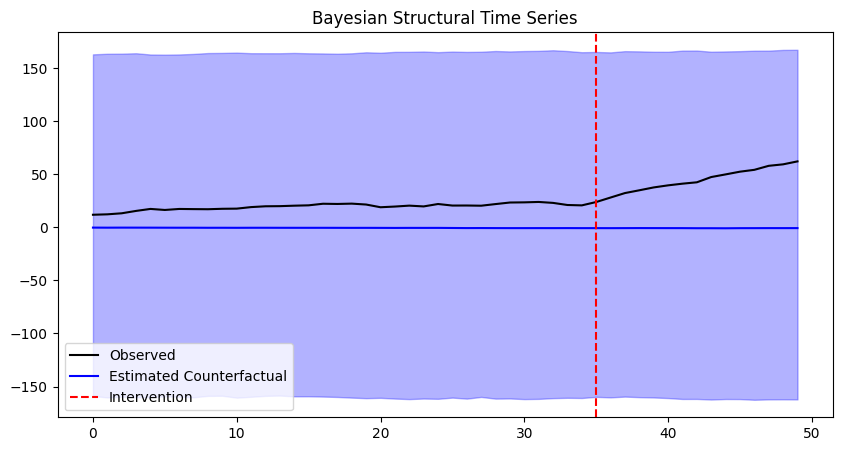

In [ ]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

# Simulated data
np.random.seed(0)
#i had to do a lower sample size bc thsi code takes forever to run. it took me like 2 mintues when n=10
#and for some reason, n=100 just refused to produce a plot???
n = 50
pre_period = 35
post_period = n - pre_period

true_level = 10
noise = np.random.normal(0, 1, n)
y = np.empty(n)
y[0] = true_level + noise[0]
for t in range(1, pre_period):
    y[t] = y[t-1] + noise[t]

intervention_effect = 3
for t in range(pre_period, n):
    y[t] = y[t-1] + noise[t] + intervention_effect

time = np.arange(n)

# Bayesian structural time series 
with pm.Model() as model:
    sigma_level = pm.Exponential("sigma_level", 1.0)
    sigma_obs = pm.Exponential("sigma_obs", 1.0)
    level = pm.GaussianRandomWalk("level", sigma=sigma_level, shape=n)
    y_obs = pm.Normal("y_obs", mu=level, sigma=sigma_obs, observed=y)
    trace = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True)

# Sample posterior predictive 
with model:
    ppc = pm.sample_posterior_predictive(trace, var_names=["level"])

# Access posterior predictive draws
level_ppc = ppc.posterior_predictive['level'].values  # shape: (chains, draws, time)
mean_level = level_ppc.mean(axis=(0, 1))
lower = np.percentile(level_ppc, 5, axis=(0, 1))
upper = np.percentile(level_ppc, 95, axis=(0, 1))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(time, y, label="Observed", color='black')
plt.plot(time, mean_level, label="Estimated Counterfactual", color='blue')
plt.axvline(pre_period, color='red', linestyle='--', label='Intervention')
plt.fill_between(time, lower, upper, color='blue', alpha=0.3)
plt.legend()
plt.title("Bayesian Structural Time Series")
plt.show()


# Stretch Goal: Manual implemntation of Gibbs Samploing

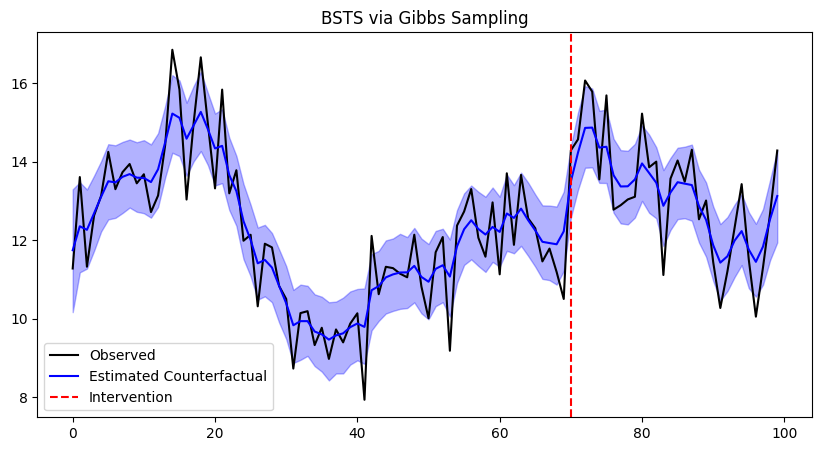

In [16]:
from scipy.stats import invgamma, norm

np.random.seed(0)

# Simulate data
n = 100
pre_period = 70
true_level = 10
obs_sigma = 1.0
state_sigma = 0.5
mu = np.zeros(n)
y = np.zeros(n)
mu[0] = true_level + np.random.normal(0, state_sigma)
y[0] = mu[0] + np.random.normal(0, obs_sigma)

for t in range(1, n):
    mu[t] = mu[t-1] + np.random.normal(0, state_sigma)
    if t >= pre_period:
        y[t] = mu[t] + 3 + np.random.normal(0, obs_sigma)  # intervention
    else:
        y[t] = mu[t] + np.random.normal(0, obs_sigma)

# Gibbs Sampler settings
n_iter = 1000
burn_in = 200
mu_samples = np.zeros((n_iter - burn_in, n))
sigma2_samples = np.zeros(n_iter - burn_in)
tau2_samples = np.zeros(n_iter - burn_in)

# Priors
alpha_sigma, beta_sigma = 1, 1
alpha_tau, beta_tau = 1, 1

# Initial values
sigma2 = 1.0
tau2 = 1.0
mu_curr = np.zeros(n)

# FFBS helper
def sample_mu_ffbs(y, sigma2, tau2):
    n = len(y)
    mu = np.zeros(n)
    # Forward filtering
    m = np.zeros(n)
    C = np.zeros(n)
    a = np.zeros(n)
    R = np.zeros(n)
    
    m[0] = 0
    C[0] = 10
    
    for t in range(1, n):
        a[t] = m[t-1]
        R[t] = C[t-1] + tau2
        Q = R[t] + sigma2
        A = R[t] / Q
        m[t] = a[t] + A * (y[t] - a[t])
        C[t] = (1 - A) * R[t]
    
    # Backward sampling
    mu[n-1] = np.random.normal(m[n-1], np.sqrt(C[n-1]))
    for t in reversed(range(n-1)):
        B = C[t] / (C[t] + tau2)
        mean = m[t] + B * (mu[t+1] - m[t])
        var = C[t] - B * C[t]
        mu[t] = np.random.normal(mean, np.sqrt(var))
    
    return mu

# Gibbs sampling loop
for i in range(n_iter):
    # 1. Sample latent mu
    mu_curr = sample_mu_ffbs(y, sigma2, tau2)
    
    # 2. Sample sigma^2 | y, mu
    resid_obs = y - mu_curr
    alpha_post = alpha_sigma + n / 2
    beta_post = beta_sigma + 0.5 * np.sum(resid_obs**2)
    sigma2 = invgamma.rvs(alpha_post, scale=beta_post)
    
    # 3. Sample tau^2 | mu
    resid_state = np.diff(mu_curr)
    alpha_post = alpha_tau + (n - 1) / 2
    beta_post = beta_tau + 0.5 * np.sum(resid_state**2)
    tau2 = invgamma.rvs(alpha_post, scale=beta_post)
    
    # Store samples
    if i >= burn_in:
        mu_samples[i - burn_in] = mu_curr
        sigma2_samples[i - burn_in] = sigma2
        tau2_samples[i - burn_in] = tau2

# Posterior mean and intervals
mu_mean = mu_samples.mean(axis=0)
mu_lower = np.percentile(mu_samples, 5, axis=0)
mu_upper = np.percentile(mu_samples, 95, axis=0)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(y, label="Observed", color='black')
plt.plot(mu_mean, label="Estimated Counterfactual", color='blue')
plt.fill_between(np.arange(n), mu_lower, mu_upper, color='blue', alpha=0.3)
plt.axvline(pre_period, color='red', linestyle='--', label='Intervention')
plt.legend()
plt.title("BSTS via Gibbs Sampling")
plt.show()
